1. XGBoost doesn't predict unseen data
2. Get_dummies

In [240]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from scipy import stats
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt

In [241]:
import dask
from dask.distributed import Client, progress

In [242]:
my_dir = r'/Users/bogdanivtsjenko/Projects/Notebooks/Data'
filelist = []
os.chdir( my_dir )
for files in glob.glob( "*.csv" ) :
    filelist.append(files)

In [243]:
filelist

['HomeCredit_columns_description (1).csv',
 'application_test.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [244]:
df_train = pd.read_csv(filelist[5],index_col=None, header=0, encoding = "ISO-8859-1")
df_train_payments = pd.read_csv(filelist[4],index_col=None, header=0, encoding = "ISO-8859-1")
df_credit_balance = pd.read_csv(filelist[3],index_col=None, header=0, encoding = "ISO-8859-1")
df_bureau = pd.read_csv(filelist[6],index_col=None, header=0, encoding = "ISO-8859-1")

In [245]:
df_test = pd.read_csv(filelist[1],index_col=None, header=0, encoding = "ISO-8859-1")

In [246]:
# Read, multiplu by -1 and create new column DAYS_TO_LATE & AMT_TO_SHORT
df_train_payments["DAYS_PAYMENT_DELTA"] = df_train_payments.loc[:,'DAYS_INSTALMENT'].apply(lambda x: x*-1)
df_train_payments["DAYS_PAYMENT_DELTA"]= df_train_payments.loc[:,'DAYS_ENTRY_PAYMENT']*-1
df_train_payments["DAYS_TO_LATE"] = df_train_payments["DAYS_ENTRY_PAYMENT"] - df_train_payments["DAYS_INSTALMENT"]
df_train_payments["AMT_TO_SHORT"] = df_train_payments["DAYS_ENTRY_PAYMENT"] - df_train_payments["DAYS_INSTALMENT"]
df_train_payments["DAYS_TO_LATE"] = df_train_payments["DAYS_TO_LATE"].apply(lambda x: x*-1)
df_train_payments["AMT_TO_SHORT"] = df_train_payments["AMT_TO_SHORT"]*-1
df_train_payments = df_train_payments.groupby(["SK_ID_CURR"], as_index=False).mean()

In [247]:
#Merge TRAIN_PAYMENTS
df_train = pd.merge(df_train,df_train_payments[['SK_ID_CURR','DAYS_TO_LATE']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_train_payments[['SK_ID_CURR','AMT_TO_SHORT']],on='SK_ID_CURR', how='left')

df_test = pd.merge(df_test,df_train_payments[['SK_ID_CURR','DAYS_TO_LATE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_train_payments[['SK_ID_CURR','AMT_TO_SHORT']],on='SK_ID_CURR', how='left')

In [248]:
df_bureau = df_bureau.groupby(["SK_ID_CURR"], as_index=False).mean()

In [249]:
#Merge BUREAU
df_train = pd.merge(df_train,df_bureau[['SK_ID_CURR','CREDIT_DAY_OVERDUE']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_bureau[['SK_ID_CURR','CREDIT_DAY_OVERDUE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']],on='SK_ID_CURR', how='left')

In [250]:
df_credit_balance = df_credit_balance.groupby(["SK_ID_CURR"], as_index=False).mean()

In [251]:
df_test = pd.merge(df_test,df_credit_balance[['SK_ID_CURR','SK_DPD']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_credit_balance[['SK_ID_CURR','SK_DPD']],on='SK_ID_CURR', how='left')

# Dummies 

In [252]:
#df_train.dropna()

## Feature selection

In [253]:
#select numerical columns
df_train.select_dtypes(include=[np.number])
df_test.select_dtypes(include=[np.number])

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,...,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_TO_LATE,AMT_TO_SHORT,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,SK_DPD
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,...,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,0.0392,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.285714,7.285714,0.0,0.0,NaN
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,23.555556,23.555556,0.0,0.0,NaN
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,2.0,2,2,14,0,0,0,0,0,0,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,5.180645,5.180645,0.0,0.0,0.010417
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,4.0,2,2,11,0,0,0,0,0,0,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.3200,0.2759,0.3750,0.0417,0.2042,0.2404,0.3673,0.0386,0.0800,0.3109,0.2049,0.9970,0.9608,0.1176,...,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.3750,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,0.3700,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,3.000000,3.000000,0.0,0.0,0.000000
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,3.0,2,2,5,0,0,0,0,1,1,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,12.250000,12.250000,NaN,NaN,NaN
5,100042,0,270000.0,959688.0,3460

In [255]:
df_train = df_train[["SK_ID_CURR", "TARGET", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT"]]
df_test = df_test[["SK_ID_CURR", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT"]]

In [256]:
df_train = df_train.fillna(df_train.mean())
df_test  = df_test.fillna(df_train.mean())

In [236]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df_train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT"]]
Y = df_train["TARGET"]
names = df_train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT"]]
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.21659999999999999, 'DAYS_EMPLOYED'), (0.18940000000000001, 'AMT_ANNUITY'), (0.1434, 'AMT_CREDIT'), (0.13880000000000001, 'DAYS_TO_LATE'), (0.13830000000000001, 'AMT_TO_SHORT'), (0.11890000000000001, 'AMT_INCOME_TOTAL'), (0.0298, 'SK_DPD'), (0.0137, 'AMT_CREDIT_SUM_OVERDUE'), (0.0111, 'CREDIT_DAY_OVERDUE')]


# XGboost

In [257]:
# split data into X and y
X = df_train[['SK_ID_CURR', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_TO_SHORT', 'DAYS_TO_LATE', 'AMT_INCOME_TOTAL', 'SK_DPD']]
Y = df_train["TARGET"]

# predict data
X_test_unseen = df_test[['SK_ID_CURR', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_TO_SHORT', 'DAYS_TO_LATE', 'AMT_INCOME_TOTAL', 'SK_DPD']]

In [258]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [259]:
model = XGBClassifier()
model.fit(X_train, y_train)

#Accurancy
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [260]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.98%


In [303]:
# predict unseen data -> results with and without propabilities
y_pred_new = model.predict_proba(X_test_unseen)[:,1]
y_pred_new_1 = model.predict(X_test_unseen)

y_pred_prob = model.predict_proba(X_test)

/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


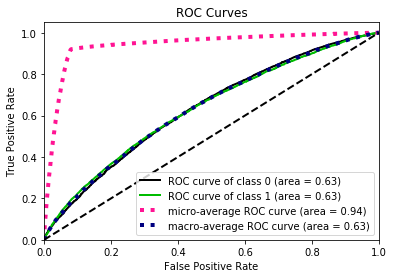

In [304]:
y_true = y_test
y_probas = y_pred_prob
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [305]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

df_test['TARGET'] = y_pred_new.tolist()
df_test['target'] = y_pred_new_1.tolist()

In [306]:
df_test

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,SK_DPD,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,DAYS_EMPLOYED,DAYS_TO_LATE,AMT_TO_SHORT,prob,target,TARGET
0,100001,135000.0,568800.0,20560.5,4.209093,0.000000,0.000000,-2329,7.285714,7.285714,0.079235,0,0.079235
1,100005,99000.0,222768.0,17370.0,4.209093,0.000000,0.000000,-4469,23.555556,23.555556,0.059349,0,0.059349
2,100013,202500.0,663264.0,69777.0,0.010417,0.000000,0.000000,-4458,5.180645,5.180645,0.045534,0,0.045534
3,100028,315000.0,1575000.0,49018.5,0.000000,0.000000,0.000000,-1866,3.000000,3.000000,0.054347,0,0.054347
4,100038,180000.0,625500.0,32067.0,4.209093,1.035863,49.549302,-2191,12.250000,12.250000,0.096140,0,0.096140
5,100042,270000.0,959688.0,34600.5,0.023810,0.000000,0.000000,-12009,6.115385,6.115385,0.042482,0,0.042482
6,100057,180000.0,499221.0,22117.5,4.209093,0.000000,0.000000,-2580,22.000000,22.000000,0.060970,0,0.060970
7,100065,166500.0,180000.0,14220.0,4.209093,0.000000,0.000000,-1387,13.600000,13.600000,0.084170,0,0.084170
8,100066,315000.0,364896.0,28957.5,0.000000,0.000000,0.000000,-1013,9.488889,9.488889,0.118455,0,0.118455
9,100067,162000.0,45000.0,5337.0,0.034483,0.000000,0.000000,-2625,7.124224,7.124224,0.056547,0,0.056547


In [277]:
df_test[["SK_ID_CURR", "TARGET"]]

SK_ID_CURR                  int64
AMT_INCOME_TOTAL          float64
AMT_CREDIT                float64
AMT_ANNUITY               float64
SK_DPD                    float64
CREDIT_DAY_OVERDUE        float64
AMT_CREDIT_SUM_OVERDUE    float64
DAYS_EMPLOYED               int64
DAYS_TO_LATE              float64
AMT_TO_SHORT              float64
prob                      float64
target                      int64
TARGET                    float64
dtype: object

In [296]:
df_test[df_test["target"] == 1 ]

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,SK_DPD,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,DAYS_EMPLOYED,DAYS_TO_LATE,AMT_TO_SHORT,prob,target,TARGET
